In [1]:
import os
import csv
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw
from torchvision.datasets.vision import *
import torch
import copy

In [41]:
datasets0 = [
    'iris_verification_iitd_01_01',
    'iris_verification_inno_a1_01_03',
    'iris_verification_NDCSI2013_01_05'
]
datasets = [
    'train_iris_casia_v4',
    'train_iris_inno_a1',
    'train_iris_nd_0405',
    'train_iris_nd_crosssensor_2013',
    'train_iris_utris_v1'
]

root = os.path.join('..', '..', 'Datasets')

dataset_id = 3

dataset_dir = os.path.join(root, datasets[dataset_id])
annotations_path = os.path.join(dataset_dir, 'annotations.csv')
with open(annotations_path, newline='') as csvfile:
    annotations = csv.reader(csvfile, delimiter=',', quotechar='"')
    annotations_list = list(annotations)


In [20]:
class IrisImage(object):
    def __init__(self, header: Optional[list] = None, param_list: Optional[list] = None, dataset_root: Optional[str] = None) -> None:
        super().__init__()
        self.null()
        if header and param_list and dataset_root:
            self.update(header, param_list, dataset_root)
    def null(self):
        self.param_map = {}
        self.dataset_root = None
        self.pos_x = None
        self.pos_y = None
        self.radius_0 = None
        self.radius_1 = None
        self.image_data = None
        self.image_mask = None
    def update_params(self, header: list, param_list: list):
        for key, val in zip(header, param_list):
            self.param_map[key] = val
    def update_circles(self):
        assert (
            'pos_x' in self.param_map and
            'pos_y' in self.param_map and
            'radius_0' in self.param_map and
            'radius_1' in self.param_map
        ), 'Parameter list does not contain information about circles in the header'

        self.pos_x    = float(self.param_map['pos_x'])
        self.pos_y    = float(self.param_map['pos_y'])
        self.radius_0 = float(self.param_map['radius_0'])
        self.radius_1 = float(self.param_map['radius_1'])
    def update_mask(self):
        assert (
            self.pos_x and 
            self.pos_y and 
            self.radius_0 and 
            self.radius_1
        ), 'Position of circles has not been set/updated'
        
        self.image_mask = Image.new(mode='1', size=self.image_data.size, color=0)
        image_draw = ImageDraw.Draw(self.image_mask)
        image_draw.ellipse((
            self.pos_x-self.radius_1,
            self.pos_y-self.radius_1,
            self.pos_x+self.radius_1,
            self.pos_y+self.radius_1),
        fill=1)
        image_draw.ellipse((
            self.pos_x-self.radius_0,
            self.pos_y-self.radius_0,
            self.pos_x+self.radius_0,
            self.pos_y+self.radius_0),
        fill=0)
    def reload(self):
        assert self.dataset_root, 'dataset_root is not set' 
        assert 'image_id' in self.param_map, 'Parameter list does not contain image_id in the header'
        
        image_dir = self.param_map['image_id']
        img_path = os.path.join(self.dataset_root, image_dir, 'iris_right.UNKNOWN')
        self.image_data = Image.open(img_path).convert('L')
    def update(self, header: list, param_list: list, dataset_root: str):
        self.null()
        self.dataset_root = dataset_root
        self.update_params(header, param_list)
        self.update_circles()
        self.reload()
    def get(self):
        assert self.image_data, 'No image is loaded, cannot get a copy'

        return copy.deepcopy(self.image_data) 
    def get_mask(self):
        assert self.image_mask, 'No image is loaded, cannot get a copy'

        return copy.deepcopy(self.image_mask) 
    def crop(self, size: Optional[int] = None):
        assert (
            self.pos_x and 
            self.pos_y and 
            self.radius_0 and 
            self.radius_1
        ), 'Position of circles has not been set/updated'

        self.image_data = self.image_data.crop((
            self.pos_x-self.radius_1,
            self.pos_y-self.radius_1,
            self.pos_x+self.radius_1,
            self.pos_y+self.radius_1
        ))

        self.pos_x = self.radius_1
        self.pos_y = self.radius_1
        
        if size != None:
            assert type(size)== int, 'Size should be a single integer'
            
            factor = (size/2) / self.radius_1 
            self.radius_0 *= factor 
            self.radius_1 *= factor
            self.pos_x = self.radius_1
            self.pos_y = self.radius_1
            
            self.image_data = self.image_data.resize((size,size))
    def paint_circles(self):
        assert (
            self.pos_x and 
            self.pos_y and 
            self.radius_0 and 
            self.radius_1
        ), 'Position of circles has not been set/updated'

        point_radius = 5
        image_draw = ImageDraw.Draw(self.image_data)
        image_draw.ellipse((
            self.pos_x-point_radius,
            self.pos_y-point_radius,
            self.pos_x+point_radius,
            self.pos_y+point_radius),
        fill='red')
        image_draw.ellipse((
            self.pos_x-self.radius_0,
            self.pos_y-self.radius_0,
            self.pos_x+self.radius_0,
            self.pos_y+self.radius_0), 
        outline ='blue', width=point_radius)
        image_draw.ellipse((
            self.pos_x-self.radius_1,
            self.pos_y-self.radius_1,
            self.pos_x+self.radius_1,
            self.pos_y+self.radius_1), 
        outline ='green', width=point_radius)

In [21]:

class IrisDataset(VisionDataset):
    def __init__(
        self, 
        root: list, 
        image_set: str = "train",
        mode: str = "classification",
        autocrop: bool = True,
        transform: Optional[Callable] = None, 
        transforms: Optional[Callable] = None, 
        target_transform: Optional[Callable] = None
    ) -> None:
        super().__init__(root, transform=transform, transforms=transforms, target_transform=target_transform)
        
        modes = {
            "classification",
            "segmentation"
        }

        image_sets_filters = {
            "train" : ( lambda x , _ : x%20 < 15                ),
            "val"   : ( lambda x , _ : x%20 >= 15 and x%20 < 18 ),
            "test"  : ( lambda x , _ : x%20 >= 18               ),
            "verification": ( lambda x , _ : True)
        }

        assert mode in modes, f"Unsupported dataset mode {mode}, allowed option are {', '.join(i for i in modes)}"
        assert image_set in image_sets_filters, f"Cannot create {image_set} data split, allowed option are {', '.join(i for i in image_sets_filters)}"
        assert type(root) == list and all(type(s) == str for s in root), "Parameter root can must be list of strings"

        self.mode = mode
        self.autocrop = autocrop
        self.tmp_img = IrisImage()
        self.anotations = dict()
        self.subjects_set = dict()
        self.subjects = list()

        self.pairs = list()
        self.impostors = list()

        for dataset_dir in root:
            with open(os.path.join(dataset_dir, 'annotations.csv'), newline='') as csvfile:
                annotations = csv.reader(csvfile, delimiter=',', quotechar='"')
                self.anotations[dataset_dir] = list(annotations)
            
            header = self.anotations[dataset_dir][0]
            subject_id_idx = header.index('subject_id')
            eye_side_idx = header.index('eye_side')

            for i, entry in enumerate(self.anotations[dataset_dir][1:]):
                subject_id = entry[subject_id_idx]
                eye_side = entry[eye_side_idx]
                subject_id_combined = f"{subject_id}_{eye_side}"
                if not subject_id_combined in self.subjects_set:
                    self.subjects_set[subject_id_combined] = list()
                self.subjects_set[subject_id_combined].append(len(self.subjects))
                self.subjects.append( (subject_id_combined, dataset_dir, i+1) )

        self.subject_to_id_dict = dict(map((lambda x : (x[1],x[0])), enumerate(self.subjects_set)))
        self.id_to_subject_dict = dict(enumerate(self.subjects_set))
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is a tuple of all target types
        """

        subject = self.subjects[index]
        header = self.anotations[subject[1]][0]
        param_list = self.anotations[subject[1]][subject[2]]
        dataset_root = subject[1]

        self.tmp_img.update(header,param_list,dataset_root)
        
        if self.autocrop:
            self.tmp_img.crop()

        img = self.tmp_img.get()

        if self.transform is not None:
            img = self.transform(img)

        if self.mode == "classification":
            target = self.subject_to_id_dict[subject[0]]
            if self.target_transform is not None:
                target = self.target_transform(target)
        elif self.mode == "segmentation":
            self.tmp_img.update_mask()
            target = self.tmp_img.get_mask()
            if self.transforms is not None:
                img, target = self.transforms(img, target)
        else:
            assert False, "Unsupported dataset mode"

        return img, target
    def __len__(self) -> int:
        return len(self.subjects)


In [23]:
ds = IrisDataset([dataset_dir], mode="classification")

0 nd1S05368_1
5 nd1S04233_2
10 nd1S05448_2
15 nd1S05500_1


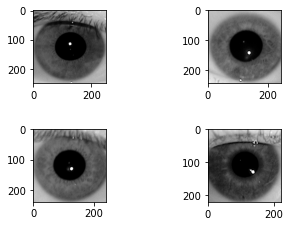

In [35]:
for i in range(4):
    ind = i*30
    img, target = ds[ind]
    ax1 = plt.subplot(2,4,(i*2+1))
    ax1.imshow(img, 'gray')
    if type(target) == int:
        print(target, ds.id_to_subject_dict[target])
    else:
        ax1 = plt.subplot(2,4,(i*2+2))
        ax1.imshow(target)


In [13]:
len(ds.subjects_set[''])

195

In [110]:
header = annotations_list[0]
params = annotations_list[2]

In [111]:
print( '\n'.join("{:<20}: {:<28}".format(*k) for k in zip(header, params) ) )

                    : 1                           
YOB                 : 1978                        
added_by            : dthomas4                    
by_user             : sbaker3                     
collectionid        : nd1C00013                   
confidence          : 0.9999563097953796          
contacts            : No                          
contacts_cosmetic   : No                          
contacts_texture    : No                          
contacts_toric      : No                          
date                : 2008-04-01 00:00:00         
date_added          : 2008-08-12 18:12:10         
db_id               : iris_nd_crosssensor_2013    
detection_info      : iface 3.9.0                 
environmentid       : nd1E00074                   
eye_color           : Brown                       
eye_side            : 1                           
fold                : 1                           
fstate              : ok                          
gender              : 2        

In [112]:
img = DatasetImage(header, params, dataset_dir)

In [113]:
img.update(header, params, dataset_dir)
img.crop(256)
img.update_mask()

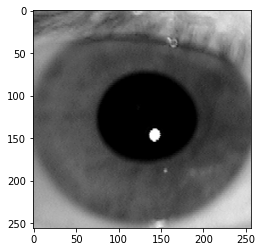

In [114]:
plt.imshow(img.image_data)

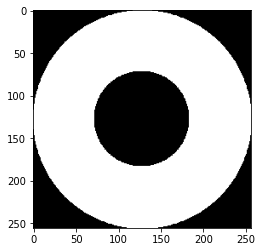

In [115]:
plt.imshow(img.image_mask)

In [44]:
import pandas as pd

In [46]:
df = pd.read_csv( annotations_path)

In [66]:
df.groupby(['subject_id','eye_side']).count()

Unnamed: 0  YOB  added_by  by_user  collectionid  \
subject_id eye_side                                                     
nd1S02463  1                315  315       315      315           315   
           2                323  323       323      323           323   
nd1S04233  2                339  339       339      339           337   
nd1S04252  1                 36   36        36       36            36   
nd1S04261  2                215  215       215      215           215   
...                         ...  ...       ...      ...           ...   
nd1S06265  2                 39   39        39       39            39   
nd1S06266  2                 30   30        30       30            30   
nd1S06267  1                 29   29        29       29            29   
nd1S06269  1                 30   30        30       30            30   
           2                 30   30        30       30            30   

                     confidence  contacts  contacts_cosmetic  \
subject_id eye_side                                            
nd1S02463  1                315       315                315   
           2                323       323                323   
nd1S04233  2                339       339                339   
nd1S04252  1                 36        36                 36   
nd1S04261  2                215       215                215   
...                         ...       ...                ...   
nd1S06265  2                 39        39                 39   
nd1S06266  2                 30        30                 30   
nd1S06267  1                 29        29                 29   
nd1S06269  1                 30        30                 30   
           2                 30        30                 30   

                     contacts_texture  contacts_toric  ...  radius_1  rank  \
subject_id eye_side                                    ...                   
nd1S02463  1                      315             315  ...       315   195   
           2                      323             323  ...       323   206   
nd1S04233  2                      339             339  ...       339   219   
nd1S04252  1                       36              36  ...        36    36   
nd1S04261  2                      215             215  ...       215   125   
...                               ...             ...  ...       ...   ...   
nd1S06265  2                       39              39  ...        39     0   
nd1S06266  2                       30              30  ...        30     0   
nd1S06267  1                       29              29  ...        29     0   
nd1S06269  1                       30              30  ...        30     0   
           2                       30              30  ...        30     0   

                     sensor_name  sensorid  shot  stageid  state  treatment  \
subject_id eye_side                                                           
nd1S02463  1                 315       315   180      315    315        195   
           2                 323       323   191      323    323        206   
nd1S04233  2                 339       339   219      339    339        219   
nd1S04252  1                  36        36    36       36     36         36   
nd1S04261  2                 215       215   125      215    215        125   
...                          ...       ...   ...      ...    ...        ...   
nd1S06265  2                  39        39     0       39     39          0   
nd1S06266  2                  30        30     0       30     30          0   
nd1S06267  1                  29        29     0       29     29          0   
nd1S06269  1                  30        30     0       30     30          0   
           2                  30        30     0       30     30          0   

                     validity  weather  
subject_id eye_side                     
nd1S02463  1              315      315  
           2              323      323  
nd1S04233  2              339  

In [68]:
df[df['subject_id'] == 'nd1S02463']

,Unnamed: 0,YOB,added_by,by_user,collectionid,confidence,contacts,contacts_cosmetic,contacts_texture,contacts_toric,...,rank,sensor_name,sensorid,shot,stageid,state,subject_id,treatment,validity,weather
308,393,1956,dthomas4,flynn,nd1C00013,0.999991,No,No,No,No,...,0.0,LG2200,nd1N00006,1.0,nd1T00014,ok,nd1S02463,No,1,Inside
309,394,1956,dthomas4,flynn,nd1C00013,0.999996,No,No,No,No,...,0.0,LG2200,nd1N00006,1.0,nd1T00014,ok,nd1S02463,No,1,Inside
310,395,1956,dthomas4,flynn,nd1C00013,0.999993,No,No,No,No,...,0.0,LG2200,nd1N00006,1.0,nd1T00014,ok,nd1S02463,No,1,Inside
311,396,1956,dthomas4,flynn,nd1C00013,0.999974,No,No,No,No,...,0.0,LG2200,nd1N00006,2.0,nd1T00014,ok,nd1S02463,No,1,Inside
312,397,1956,dthomas4,flynn,nd1C00013,0.999991,No,No,No,No,...,0.0,LG2200,nd1N00006,2.0,nd1T00014,ok,nd1S02463,No,1,Inside
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101013,145601,1956,chelm,dwright2,nd1C00042,0.999978,No,No,No,No,...,NaN,LG4000,nd1N00020,NaN,nd1T00016,ok,nd1S02463,NaN,1,Inside
101014,145602,1956,chelm,dwright2,nd1C00042,0.999922,No,No,No,No,...,NaN,LG4000,nd1N00020,NaN,nd1T00016,ok,nd1S02463,NaN,1,Inside
101015,145603,1956,chelm,dwright2,nd1C00042,0.999981,No,No,No,No,...,NaN,LG4000,nd1N00020,NaN,nd1T00016,ok,nd1S02463,NaN,1,Inside
101016,145604,1956,chelm,dwright2,nd1C00042,0.999952,No,No,No,No,...,NaN,LG4000,nd1N00020,NaN,nd1T00016,ok,nd1S02463,NaN,1,Inside


In [76]:
df['validity'].max()

1